# Instructions 

* Please find and download part of the LibriSpeech [here](http://www.openslr.org/12/). Find some time to read the documentation of the database. Download the dev-clean corpus, which is relative small in size. This database contains directories with ids. Each id represents one speaker and contains audio files associated with that speaker. You will also find a file that indicates the gender of each speaker.
* In case you have computational issues, please feel free to select a subset of the dataset. However, try to keep at least 18 speakers (8 male and 8 female).
* The next step would be to extract features for the audio files. The most common type of features are the MFCC features. Feel free to use existing libraries in order to extract MFCC features for all the audio files of your dataset.
* Once you have the MFCC features extracted, you can start playing with various Machine Learning Algorithms. We would like you to perform a gender classification task. For each audio file you create a gender label. Build train and test (unseen while training) sets. Train a classifier on the train set and predict the labels of the test set. Measure accuracy and report performance. Try to experiment with at least 4 classifiers. Use two of them as baselines (one naive and one more sophisticated), a neural network and a deep learning model, such as a CNN. Once again, feel free to use any libraries that are convenient for you.
* For the aforementioned tasks, analyse and interpret the results. Don’t focus only on numbers. Try to explain why an algorithm performs better/worse than the others. The important part for us is to see the way you think and deal with a project like that. Don’t be afraid of interpreting the results and making mistakes. We are not going to judge that negatively :)
* It would be great to use Jupyter Notebook for this assignment. Please try to show us your coding skills. Clean code with comments and correct programming principles are much appreciated. 

# Introduction : resolution of exercise plan

After downlaoding the `dev-clean` corpus of the dataset and going through the files and documentation it countain, I decided firstly to explore the `SPEAKERS.TXT` file which enclose informations about the whole LibriSpeech dataset. To do so, I will use [Pandas](http://pandas.pydata.org/pandas-docs/stable/) library to extract informations and perform some cleaning as only informations relative to the `dev-clean` corpus is relevant for the task. After that, I will plot some figures to have a quick visual overview of the data we are dealing with.

In a second part of the assignement, I will read the audio files and store them as numpy arrays using the [PySoundFile](https://pysoundfile.readthedocs.io/en/0.9.0/) library. Then, to extract the MFCC features from the audio files I will use [bob](https://www.idiap.ch/software/bob/) library, a Python wrapper developped by [idiap](https://www.idiap.ch/en) for the [Kaldi ASR](http://kaldi-asr.org) C++ library which is mentionned on the LibriSpeech dataset website. <br>
*NOTE* : I will use the default settings of the bob library to compute MFCC of audio signals. Those default settings are computing MFCC over windows of 20ms, with a shift of 10ms. It uses 24 filters bands and 19 cepstral coefficients. Hence, for example, a file of 1sec=1000ms would return an array of shape (99,19). The number of cepstral coefficient is unusual compared to the most commonly used number of 13 cepstral coefs that I could come accross in literature. However, after a first bunch of concluant experiments, I decided not to play with the default settings and trust the implementation made by idiap's expert in speech processing.

Once I have the MFCC features, the interesting part of Machine Learning begins ;) <br>
I will explore two different approaches to perform the gender classification : 
- First approach is to consider the best case scenario, where one have access to a large amount of data (several minutes of speech) for each speakers.
- Second approach is to consider a more likely scenario, where one has access to a very limited amount of data (few seconds of data) for each speakers.

In both cases, the baseline method considered is a KNN classifiers with the same amount of neighbors. Other classfication methods will be used, like Logistic Regression and Decision Tree Classifier. To perform those methods, [Scikit-Learn](http://scikit-learn.org/stable/) library will be used. Then, I will perform a simple neural network with two fully connected layers and a convolutional network wiht one convolutional layer and one fully connected layer. Those two model will be implemented with the help of [TensorFlow](https://www.tensorflow.org). While exploring the second approach, some more steps will be done as well as an other classfier using Random Forest method will be used. <br>
To compare all models accordingly, the metric score used is the accuracy and a final plot with a recap of every accuracy for each methods will be plotted and discussed.


## Import necessary libraries for exercise, set path for files

In [1]:
# common libraries to use for data handling and plotting
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#library to read flac files
import soundfile as sf
# library to compute mfcc
import bob.ap

# libraries for Machine learning 
from sklearn.model_selection import train_test_split
# simple KNN classifier 
from sklearn.neighbors import KNeighborsClassifier #baseline 1
# simple linear models
from sklearn.linear_model import LogisticRegression
# simple tree classifier model
from sklearn.tree import DecisionTreeClassifier
# second approach extra steps
from sklearn.model_selection import GridSearchCV
# libraries used for neural net part
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder


# path to SPEAKERS.TXT file
PATH_LABELS = os.path.join('data', 'LibriSpeech', 'SPEAKERS.TXT')
# path to audio files
AUDIO_FILES_PATH = os.path.join('data', 'LibriSpeech', 'dev-clean')

# `SPEAKERS.TXT` file data exploration

The file can be opened in a simple text reader app. This allow us to see that the first lines of the file countain a description of the different informations held by each columns : <br>
`; Some pipe(|) separated metadata about all LibriVox readers, whose work was use; Some pipe(|) separated metadata about all LibriVox readers, whose work was use; Some pipe(|) separated metadata about all LibriVox readers, whose work was use; Some pipe(|) separated metadata about all LibriVox readers, whose work was used
; in the corpus.
;
; The meaning of the fields in left-to-right order is as follows:
;
; reader_id: the ID of the reader in the LibriVox's database
; gender: 'F' for female, 'M' for male
; subset: the corpus subset to which the reader's audio is assigned
; duration: total number of minutes of speech by the reader, included in the corpus 
; name: the name under which the reader is registered in LibriVox 
; 
;ID  |SEX| SUBSET           |MINUTES| NAME`

Those rows will be skipped. The read_csv method from panda will be used to create a dataframe, the `NAME` information will not be considered as we don't have interest in this information.

In [2]:
speakers_df = pd.read_csv(PATH_LABELS, skiprows=12, sep='|', usecols= [0, 1, 2, 3], names = ['ID', 'SEX', 'SUBSET', 'MINUTES'])
speakers_df.dtypes

ID           int64
SEX         object
SUBSET      object
MINUTES    float64
dtype: object

As visible above, the dataframe automatically converted `ID`and `MINUTES` as numbers, and `SEX` and `SUBSET` are passed as object strings. However, as the txt file was badly formatted and I used a custom separator, we need to remove the additional spaces around the relevant information for the columns `SEX` and `SUBSET`. Then we will have a clean dataframe  

In [3]:
# remove space character from strings 
speakers_df['SUBSET'] = speakers_df['SUBSET'].str.replace(" ", "")
speakers_df['SEX'] = speakers_df['SEX'].str.replace(" ", "")

# we only consider the dev_clean dataset, hence other entry don't concern us
dev_clean_df = speakers_df[speakers_df['SUBSET'].isin(['dev-clean'])]
dev_clean_df.head()

,ID,SEX,SUBSET,MINUTES
46,84,F,dev-clean,8.02
93,174,M,dev-clean,8.04
135,251,M,dev-clean,8.04
200,422,M,dev-clean,8.38
279,652,M,dev-clean,8.31


Let's explore the repartition of sex in the dataset we consider and plot it in a nice pie chart to easily see the distribution. We see that the dataset is balanced as there is 50% of each genders.

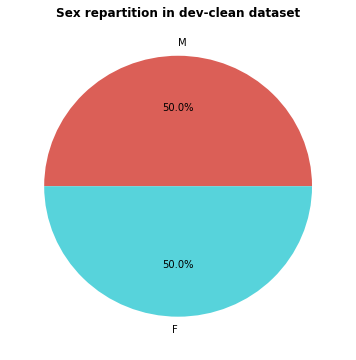

In [4]:
sns.set_palette('hls', 2)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.set_title('Sex repartition in dev-clean dataset' , fontsize=12, fontweight='bold')
g = ax.pie(dev_clean_df['SEX'].value_counts().values, labels=dev_clean_df['SEX'].value_counts().keys(), autopct='%1.1f%%')


Below there is an histogram to have a quick overview of the speaking time for each speaker. We see that for each speaker, the dataset countain approximately 8 minutes of speech.

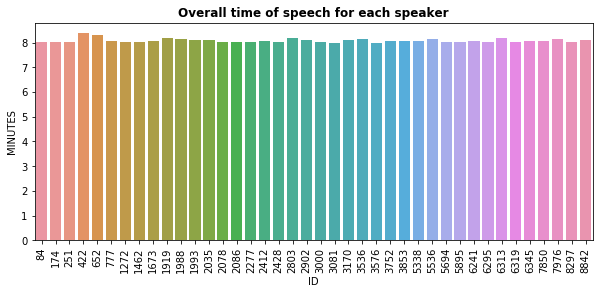

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.set_title('Overall time of speech for each speaker', fontsize=12, fontweight='bold')
ax.set_ylabel('Time (in minutes)')
[lab.set_rotation(90) for lab in ax.get_xticklabels()]
g = sns.barplot(x=dev_clean_df['ID'], y = dev_clean_df['MINUTES'], ax=ax)


# Audio file reading and MFCC extraction

The dataset folder is organised as shown below : <br>
`- LibriSpeech 
---- dev-clean 
-------- speaker id 
------------ book id
---------------- audio file ` 

Therefore, to access the audio file, the best way is to perform a sweep through all subdirectories of the `dev-clean` folder. This task is performed in a way to have all audio files arranged per speaker, hence the sweep is performed with the speaker id level as root. <br>
In the loop below, for each speakers, the MFCC features are extracted from the audio file and stored in an array such that all speech samples are concatened in an array of dimension (total_len_speech, 19), with total_len_speech being the converted length of the whole speech (~8 minutes). The latter is stored in a list where each row correspond to a specific speaker.

In [6]:
list_mfcc = []

# get list of all subdirectories  - aka retrieve all tags of speakers
speakers_list = next(os.walk(AUDIO_FILES_PATH))[1]

# for each speaker, go into each subfiles to get mfcc for all audio samples
for sub_directory in speakers_list:
        
    # create an empty mfcc array mandatory to concatenate all audio samples
    mfccs = np.empty([1,19])
    SPEAKER_PATH = os.path.join(AUDIO_FILES_PATH, sub_directory)
    
    for root, dirs, files in os.walk(SPEAKER_PATH, topdown=True):
        
        for file in files:
            # ignore hidden files starting with .xxx
            if not file.startswith('.') and not file.endswith(".txt"):
                
                SPEAKER_SUBDIR_PATH = os.path.relpath(root)
                
                audio_numpy, sample_rate = sf.read(os.path.join(SPEAKER_SUBDIR_PATH, file))
                ceps = bob.ap.Ceps(sample_rate)

                mfcc = (ceps(audio_numpy))
                mfccs = np.concatenate([mfccs, mfcc], axis=0)

    # delete the useless empty first row of the mfcc used for initializing concatenation           
    mfccs = np.delete(mfccs, 0, 0)
    # put all mfcc of one speaker into the final list countaining all speakers
    list_mfcc.append(mfccs)

    print('MFCC computed for speaker', sub_directory)

MFCC computed for speaker 2412
MFCC computed for speaker 2078
MFCC computed for speaker 3752
MFCC computed for speaker 1988
MFCC computed for speaker 1919
MFCC computed for speaker 422
MFCC computed for speaker 3000
MFCC computed for speaker 1993
MFCC computed for speaker 6313
MFCC computed for speaker 251
MFCC computed for speaker 8842
MFCC computed for speaker 5536
MFCC computed for speaker 7850
MFCC computed for speaker 174
MFCC computed for speaker 6295
MFCC computed for speaker 7976
MFCC computed for speaker 2803
MFCC computed for speaker 777
MFCC computed for speaker 5694
MFCC computed for speaker 1462
MFCC computed for speaker 5895
MFCC computed for speaker 2086
MFCC computed for speaker 6241
MFCC computed for speaker 2277
MFCC computed for speaker 2428
MFCC computed for speaker 3536
MFCC computed for speaker 2902
MFCC computed for speaker 8297
MFCC computed for speaker 3081
MFCC computed for speaker 6345
MFCC computed for speaker 652
MFCC computed for speaker 3853
MFCC computed

As the sweep done by the os.walk method is done in a different order than the ordered dataframe created from the `SPEAKER.txt` file, it is necessary to create a new list corresponding to the new order. This list will be used as labels for the classification task. Also, to ease its use by the algorithm from scikit learn, the generated label list will be in a binary format, with `False` corresponding to Female and `True` corresponding to Male

In [7]:
ordered_labels = []
for speaker in speakers_list:
    ordered_labels.append((dev_clean_df['SEX'][dev_clean_df['ID'].isin([int(speaker)])].values)[0] == 'M')
    
print(ordered_labels)

[False, True, True, False, False, True, True, False, False, True, False, True, False, True, True, True, True, True, True, False, False, True, True, False, True, False, True, True, False, False, True, False, False, False, True, True, False, False, False, False]


# First approach : consider the whole data

As mentionned in the introduction, the first approach was to consider the whole dataset. However, if taken raw, it would represent a tremendous amount of features to consider. Therefore, for every speaker and each of the 19 coefficient from the MFCC features, the mean will be computed. This will leave us with 40 rows (one per speaker) of the averaged the 19 features. Once the mean has been computed, the dataset will be split into a train set of 80% and a test set of 20% of the data. We will have 32 speakers to train the model, and 8 speaker to assess its performances.

In [8]:
mean_mfcc = []
for speaker in list_mfcc:
    mean_mfcc.append(np.mean(speaker, axis=0))

x_train_whole, x_test_whole, y_train_whole, y_test_whole = train_test_split(np.asarray(mean_mfcc), np.asarray(ordered_labels), test_size=0.2, random_state=1)

print('Train set explanatory variables shape', x_train_whole.shape, 'and label shape', y_train_whole.shape)
print('Test set explanatory variables size', x_test_whole.shape, 'and label shape', y_test_whole.shape)

Train set explanatory variables shape (32, 19) and label shape (32,)
Test set explanatory variables size (8, 19) and label shape (8,)


Before going further with any model, the function pairplot from [seaborn](http://seaborn.pydata.org) library, is a powerful tool that can be used to determine a possible correlation between different variables of a dataframe. I find it interesting to plot it, as to see if the human eye could detect "spot on" correlations between features. <br>
In the case here, Male features are plotted in blue and Females in red. We do not see in the figures below that a strict difference of distibutions between Male or Female features can be easily spotted, but we can see that for some paired variables there is a distinguishable difference of distribution. <br>
That beeing said, let see if a model will be able to correctly classify the gender of a speaker.

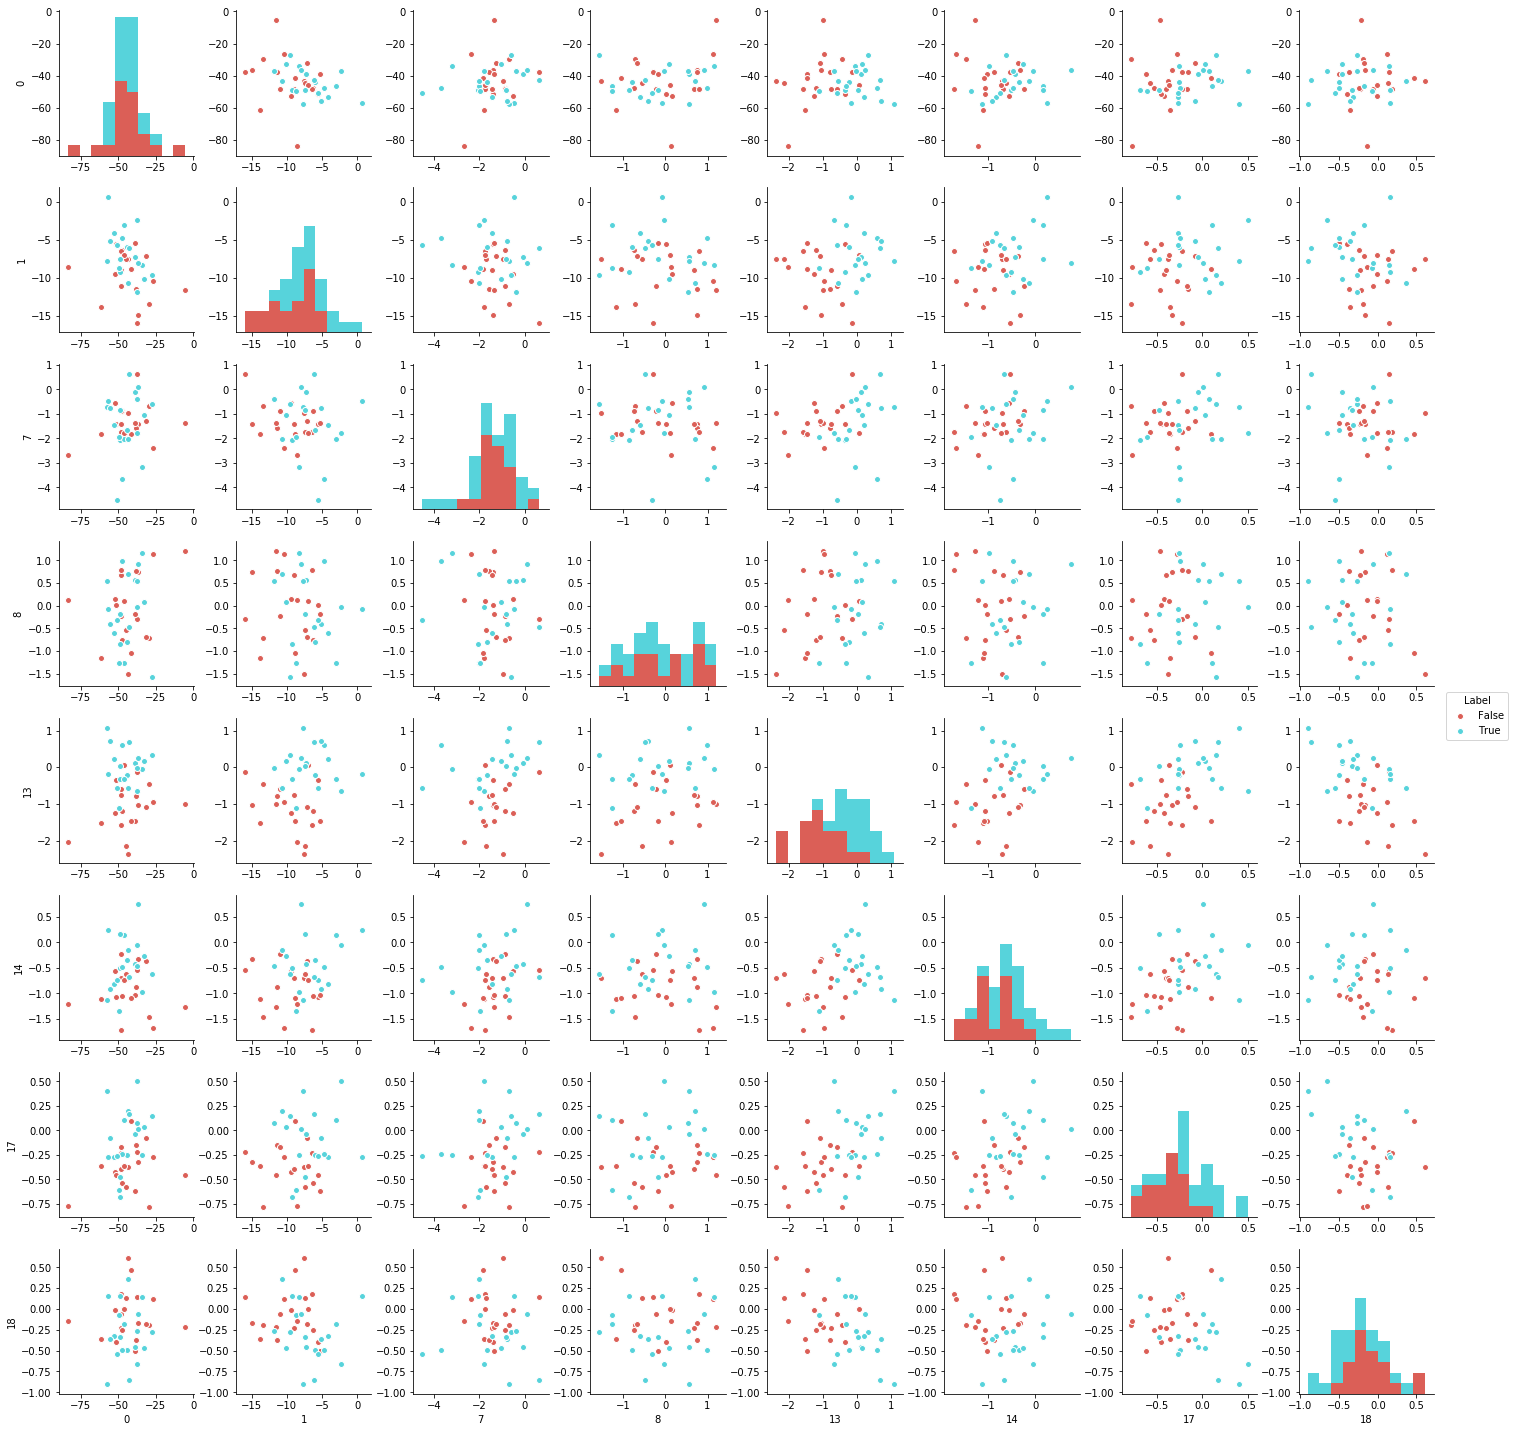

In [9]:
df = pd.DataFrame(mean_mfcc)
df['Label'] = ordered_labels
sns.pairplot(df, vars=[0, 1, 7, 8, 13, 14, 17,18], hue='Label')

In [10]:
def binary_to_gender(binary_vector):
    # This function take as input a binary vector and will return
    # a vector of the same length with the gender corresponding
    # False = Female, True = Male
    gender_pred=[]
    for gender in binary_vector:
        if gender: gender_pred.append('M')
        else: gender_pred.append('F')
        
    return gender_pred

#### Machine learning methods
Let's begin with the ML methods. The first one that I use, as a baseline, is a supervised K Nearest Neighbors classifier. A number of 2 neighbors will be used to train the model. <br>
This model has an accuracy of 87.5 %, meaning that it classified correctly the gender of 7 speakers out of 8 in the test set. This model works quite well here as we are a small number of observations and few number of features. 

In [11]:
clf_knn = KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(x_train_whole,y_train_whole)
y_pred_knn = binary_to_gender(clf_knn.predict(x_test_whole))
print('Predicted gender:', y_pred_knn)
acc_knn = clf_knn.score(x_test_whole, y_test_whole)
print('Accuracy of KNN classifier : {:0.2f}%'.format(acc_knn*100))

Predicted gender: ['M', 'F', 'F', 'M', 'F', 'F', 'M', 'F']
Accuracy of KNN classifier : 87.50%


The second model tested is a Logistic Regression. For this model I used the default settings of the scikit learn function. <br>
The model correctly predict the gender of all of the speakers from the test set, as its accuracy is 100%. A logistic model predict the probability that an outcome belongs to a class or the other. In this case, with such dataset, the logistic model is very powerful to predict the most probable gender of a speaker.

In [12]:
clf_log = LogisticRegression()
clf_log.fit(x_train_whole, y_train_whole)
y_pred_log = binary_to_gender(clf_log.predict(x_test_whole))
print('Predicted gender:', y_pred_log)
acc_log = clf_log.score(x_test_whole, y_test_whole)
print('Accuracy of Logistic Regression classifier : {:0.2f}%'.format(acc_log*100))

Predicted gender: ['M', 'F', 'F', 'M', 'M', 'F', 'M', 'F']
Accuracy of Logistic Regression classifier : 100.00%


Finally a Decision Tree Classifier model is tested. Again, the parameters of the models used are the default one. <br>
The resulting accuracy of the model is 87.5%, same as baseline model, meaning that 7 speakers' gender have been correctly classified. A decision tree classifier is build by sorting each observation to the most commonly occurring class of training observations in that region, recursively, until all the outcome are correctly classified or if there is no more gain of information. In the case here, the model is able to correctly build an effective decision tree given the dataset.

In [13]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(x_train_whole, y_train_whole)
y_pred_tree = binary_to_gender(clf_tree.predict(x_test_whole))
print('Predicted gender:', y_pred_tree)
acc_tree = clf_tree.score(x_test_whole, y_test_whole)
print('Accuracy of Decision Tree classifier : {:0.2f}%'.format(acc_tree*100))

Predicted gender: ['M', 'F', 'F', 'F', 'M', 'F', 'M', 'F']
Accuracy of Decision Tree classifier : 87.50%


#### Neural networks classifiers

First, the labels are converted to one hot vectors.

In [14]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train_whole.reshape(-1,1))
y_test = one_hot_encoder.fit_transform(y_test_whole.reshape(-1,1))

The first neural network classifier model is as follow : 
$$
\hat{ y } = softmax(ReLU(xW_1 + b_1)W_2 + b_2)
$$

In words, its a simple model with two fully connected layers. <br>
It takes relatively few iterations, to achieve an acceptable accuracy of 62.5% to 87.5%. However, with few iterations, the model is very unstable and it would be better to increase the number of epochs to make sure to have a good accuracy. With a high amount of iteration, the model is capable to return an accuracy of 100%.

In [15]:
def accuracy(predictions, labels):
    # this function takes as input the predicted labels and the correct labels to compute and return the accuracy
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [16]:
def model_2fc(x, Wfc1, bfc1, Wfc2, bfc2):
    # this function defines a 2 fully connected layers neural network
    # it takes as input :
    # x the explanatory variable
    # Wfc1 and Wfc2 weight variables of first and second layer
    # bfc1 and bfc2 bias variables of first and second layer
    x = tf.matmul(x, Wfc1) + bfc1
    x = tf.nn.relu(x)
    y = tf.matmul(x, Wfc2) + bfc2
    return y

In [17]:
# define variables for the model
batch_size = 8
d = x_train_whole.shape[1]
nc = 2

# inputs
x = tf.placeholder(tf.float32, [batch_size, d]);
y_label = tf.placeholder(tf.float32, [batch_size, nc]);

# first layer fully connected
nfc1 = 16
Wfc1 = tf.Variable(tf.truncated_normal([d, 8], stddev=0.1)); 
bfc1 = tf.Variable(tf.zeros([8],tf.float32)); 
# second layer fully connected
Wfc2 = tf.Variable(tf.truncated_normal([8, nc], stddev=0.1)); 
bfc2 = tf.Variable(tf.zeros([nc],tf.float32)); 

# apply model 
y = model_2fc(x, Wfc1, bfc1, Wfc2, bfc2)

# compute cross entropy error and l2 loss to regularize total loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y))
reg_loss = tf.nn.l2_loss(Wfc1) + tf.nn.l2_loss(bfc1) + tf.nn.l2_loss(Wfc2) + tf.nn.l2_loss(bfc2)
reg_par = 1e-3
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

# Accuracy
train_predict = tf.nn.softmax(y)
test_predict = tf.nn.softmax(model_2fc(tf.constant(x_test_whole, tf.float32), Wfc1, bfc1, Wfc2, bfc2))

In [18]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for i in range(500+1):
        # Batch extraction
        idx = i*batch_size % (y_train.shape[0] - batch_size)
        batch_x = x_train_whole[idx:(idx+batch_size), :]
        batch_y = y_train[idx:(idx+batch_size), :]        
        
        # Run NN for variable training (feed dictionnary with batch data, label and dropout)
        _,loss_o, prediction = sess.run([train_step, total_loss, train_predict], feed_dict={x: batch_x, y_label: batch_y})

        if not i%50:
            # Assess accuracy of batches from train set
            train_acc = accuracy(prediction, batch_y)
            print("\nIteration i={:d}, loss = {:0.4f}, train accuracy = {:0.2f}".format( i, loss_o, train_acc))
        
    # compute predicted labels and assess accuracy on test set    
    y_pred_2fc = test_predict.eval(session=sess, feed_dict={})
    acc_test_final_2fc = accuracy(y_pred_2fc, y_test)
    print("Test accuracy : {:0.2f}".format(acc_test_final_2fc))


Iteration i=0, loss = 0.9542, train accuracy = 37.50

Iteration i=50, loss = 0.6113, train accuracy = 62.50

Iteration i=100, loss = 0.6514, train accuracy = 50.00

Iteration i=150, loss = 0.8233, train accuracy = 37.50

Iteration i=200, loss = 0.6066, train accuracy = 62.50

Iteration i=250, loss = 0.6403, train accuracy = 50.00

Iteration i=300, loss = 0.7724, train accuracy = 37.50

Iteration i=350, loss = 0.6091, train accuracy = 75.00

Iteration i=400, loss = 0.6330, train accuracy = 87.50

Iteration i=450, loss = 0.7481, train accuracy = 25.00

Iteration i=500, loss = 0.6065, train accuracy = 87.50
Test accuracy : 62.50


Below we define a convolutional neural network model as:
$$
\hat{y}= softmax(Relu(x*W_{cl} + b_{cl})W_{fc} + b_{fc}
$$

In words, this neural network model is a simple one convolution layer with a fully connected layer. <br>
It takes more iterations for the convolutional model to attain a good accuracy. Again, with the relatively small number of epochs selected to train the model, the accuracy can vary a lot on test set. Same as before, it is possible to increase the number of iterations in order to achieve 100% accuracy every time.

In [19]:
def model_cnn(xin, Wcl, bcl, Wfc, bfc):
    
    x_2d = tf.reshape(xin, [-1,1,19,1]);
    x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME') + bcl
    
    # ReLU activation
    x = tf.nn.relu(x)
    
    x = tf.reshape(x, [batch_size,-1]); 
    y = tf.matmul(x, Wfc) + bfc
    return y

In [20]:
# Define variables for the model
batch_size = 8
d = x_train_whole.shape[1]
nc = 2                    

# inputs
x = tf.placeholder(tf.float32,[batch_size, d]); 
y_label = tf.placeholder(tf.float32,[batch_size,nc]); 

# Convolutional layer
K = 3   # size of the patch
F = 3   # number of filters
ncl = K*K*F
Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=tf.sqrt(2./tf.to_float(ncl)) )); 
bcl = tf.Variable(tf.zeros([F])); 

# Fully Connected layer
nfc = 1*19*F
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc)) )); 
bfc = tf.Variable(tf.zeros([nc])); 

# apply cnn model
y = model_cnn(x, Wcl, bcl, Wfc, bfc )

# Loss and l2 regularization
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y))
reg_loss = tf.nn.l2_loss(Wcl) + tf.nn.l2_loss(bcl) + tf.nn.l2_loss(Wfc) + tf.nn.l2_loss(bfc)
reg_par = 1e-3
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

# Accuracy
train_predict = tf.nn.softmax(y)
test_predict = tf.nn.softmax(model_cnn(tf.constant(x_test_whole, tf.float32), Wcl, bcl, Wfc, bfc))

In [21]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for i in range(2500+1):
        # Batch extraction
        idx = i*batch_size % (y_train.shape[0] - batch_size)
        batch_x = x_train_whole[idx:(idx+batch_size), :]
        batch_y = y_train[idx:(idx+batch_size),:]
                     
        # Run CNN for variable training (feed dictionnary with batch data, label and dropout)
        _,loss_o, prediction = sess.run([train_step, total_loss, train_predict], feed_dict={x: batch_x, y_label: batch_y})

        if not i%250:
            # print accuracy for test
            train_acc = accuracy(prediction, batch_y)
            print("\nIteration i={:d}, loss = {:0.4f}, train accuracy = {:0.2f}".format( i, loss_o, train_acc))
        

    # compute and print accuracy for test set
    y_pred_cnn = test_predict.eval(session=sess, feed_dict={})
    acc_test_final_cnn = accuracy(y_pred_cnn, y_test)
    print("Test accuracy : {:0.2f}".format(acc_test_final_cnn))


Iteration i=0, loss = 2.6254, train accuracy = 62.50

Iteration i=250, loss = 2.0876, train accuracy = 50.00

Iteration i=500, loss = 1.6370, train accuracy = 37.50

Iteration i=750, loss = 0.5907, train accuracy = 62.50

Iteration i=1000, loss = 0.4793, train accuracy = 75.00

Iteration i=1250, loss = 0.5738, train accuracy = 75.00

Iteration i=1500, loss = 0.4101, train accuracy = 100.00

Iteration i=1750, loss = 0.3236, train accuracy = 100.00

Iteration i=2000, loss = 0.4367, train accuracy = 87.50

Iteration i=2250, loss = 0.3459, train accuracy = 100.00

Iteration i=2500, loss = 0.2516, train accuracy = 100.00
Test accuracy : 100.00


### First approach conclusion

We have tested several methods and were able to predict the gender of a speaker with high accuracy for every methods (see figure below). Now let's consider what has been achieved and under what circumstances : 
   - the whole information for every sepakers has been considered, more than 8 minutes of speech for each. 
   - our training and test test are rather small, and by computing the mean of each MFCC features we are very confident to have meaningful data.
   - the simple ML models have very high accuracy for low complexity of implementation.
   - the neural networks are complex to implement, rather long to train and have similar or worst results to what can be achieved with easier methods. Also, given the small size of the data, neural networks models are not very relevant to use in this situation.

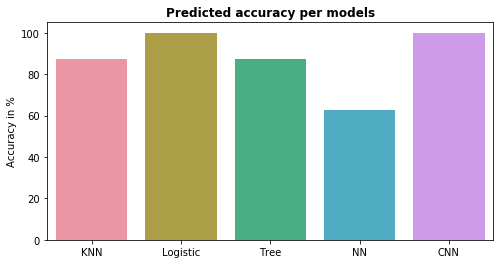

In [22]:
models = ['KNN', 'Logistic', 'Tree', 'NN', 'CNN']
accuracies = [acc_knn*100, acc_log*100, acc_tree*100, acc_test_final_2fc, acc_test_final_cnn]

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title('Predicted accuracy per models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy in %')
g = sns.barplot(x=models, y = accuracies, ax=ax)

# Second approach: use only a part of the dataset

In this approach, only a subset of random MFCC features will be kept for each speaker. The kept features will be selectected randomly and such that we will kepp 200 entries (2 seconds) of speech for each speaker. Then, rather than computing the mean, the dataset will consist of an array of size (40x200, 19). To fit accordingly, the list of labels will extended accordingly. Then, we will assess the same methods as before, once with the same parameters, once with a parametric tuning to get the best possible parameters.

*NOTE*: as we have a bit more than 8 minutes (480'000ms) of speech for each speaker, but this value varies, the randomly kept rows will never be above 47'500, which correspond to the number of entries of MFCC for less than 8 minutes of speeches. If this limit was not set, some indices could be out of range for speaker having less speech time than others.

In [23]:
import random 
nbr_samples = 200
random_samples = random.sample(range(48000), nbr_samples)

augmented_labels = np.repeat(ordered_labels, nbr_samples)

list_keeped_samples = []
for speakers in list_mfcc:
    list_keeped_samples.append(speakers[random_samples])
    
rdm_samples_kept = np.reshape(list_keeped_samples, (40*nbr_samples, 19))

print('The shape of the dataset considered for this part is:', np.shape(rdm_samples_kept))

The shape of the dataset considered for this part is: (8000, 19)


Then the dataset is split in a train and test set, same as before, 80% goes for training and 20% for testing.

In [24]:
x_train_alt, x_test_alt, y_train_alt, y_test_alt = train_test_split(np.asarray(rdm_samples_kept), np.asarray(augmented_labels), test_size=0.2, random_state=1)

print('Train set explanatory variables shape', x_train_alt.shape, 'and label shape', y_train_alt.shape)
print('Test set explanatory variables size', x_test_alt.shape, 'and label shape', y_test_alt.shape)

Train set explanatory variables shape (6400, 19) and label shape (6400,)
Test set explanatory variables size (1600, 19) and label shape (1600,)


#### Machine learning methods

Same as before, the K Nearest Neighbors will be used as baseline. Just to have a fair comparison with the model assessed in the first approach, the same number of neighbors, k=2, is used. <br>
We see that the accuracy of the KNN classifier is lower than for first method. However, it is not that bad as 71.88% means that over all, 7 out of 10 speakers are classified correctly. An explication of the worse performance of the model could be because of the expanded dimensionality of the data considered - KNN are known to perform poorly on high dimensions. This is however discutable as the amount of data is still reasonnable, hence an other explanation could be that the features used to train are less meaningful than the one used on the previous approach.

In [25]:
clf_knn = KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(x_train_alt,y_train_alt)
y_pred_neigh_alt = binary_to_gender(clf_knn.predict(x_test_alt))
#print('Predicted gender:', y_pred_knn_alt)
acc_knn_alt = clf_knn.score(x_test_alt, y_test_alt)
print('Accuracy of KNN classifier : {:0.2f}%'.format(acc_knn_alt*100))

Accuracy of KNN classifier : 71.88%


The second method tested is again Logistic Regression. The parameters are kept to default to see how well the model performs. <br>
Again, accuracy drops compared to first approach, to end at 69.81%. The model is less performant to predict the right probability of an outcome to belong to a specific class. Let's underline the fact that we are using here default parameters and a better tuning of the parameters for the model might increase the returned accuracy.

In [26]:
clf_log = LogisticRegression()
clf_log.fit(x_train_alt, y_train_alt)
y_pred_log_alt = binary_to_gender(clf_log.predict(x_test_alt))
#print('Predicted gender:', y_pred_log_alt)
acc_log_alt = clf_log.score(x_test_alt, y_test_alt)
print('Accuracy of Logistic Regression classifier : {:0.2f}%'.format(acc_log_alt*100))

Accuracy of Logistic Regression classifier : 69.81%


The Decision Tree Classifier, tested again with default parameters, performs in a range of accuracy between 67% to 69%. As expected, this model is unstable with a high number of features.

In [27]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(x_train_alt, y_train_alt)
y_pred_tree_alt = binary_to_gender(clf_tree.predict(x_test_alt))
#print('Predicted gender:', y_pred_tree_alt)
acc_tree_alt = clf_tree.score(x_test_alt, y_test_alt)
print('Accuracy of Decision Tree classifier : {:0.2f}%'.format(acc_tree_alt*100))

Accuracy of Decision Tree classifier : 67.00%


Out of curiosity, below are chunks of code that will perform a cross validation to tune the parameters and try to see if a better accuracy is achievable with those "simple" machine learning methods. It is indeed possible to achieve better performances with other parameters, as KNN performs an accuracy of 76.5% with 9 neighbors and Logistic Regression increases it score slightly to 70.19%.

In [28]:
parameters = {'n_neighbors': np.linspace(1,15,15, dtype=int)}
clf_knn = KNeighborsClassifier()
clf_knn_cv = GridSearchCV(clf_knn, parameters, cv=5, n_jobs=-1)
clf_knn_cv.fit(x_train_alt, y_train_alt)

print(clf_knn_cv.best_params_)
acc_knn_cv = clf_knn_cv.score(x_test_alt, y_test_alt)
print('Accuracy of KNN classifier with tuned parameters : {:0.2f}%'.format(acc_knn_cv*100))

{'n_neighbors': 9}
Accuracy of KNN classifier with tuned parameters : 76.50%


In [29]:
parameters = {'tol':np.logspace(-5,-2, 4), 'C':np.logspace(-6, 2, 9)}
clf_log = LogisticRegression()
clf_log_cv = GridSearchCV(clf_log, parameters, cv=5, n_jobs=-1)
clf_log_cv.fit(x_train_alt,y_train_alt)

print(clf_log_cv.best_params_)
acc_log_cv = clf_log_cv.score(x_test_alt,y_test_alt)
print('Accuracy of Logistic Regression classifier with tuned parameters : {:0.2f}%'.format(acc_log_cv*100))

{'C': 10.0, 'tol': 0.01}
Accuracy of Logistic Regression classifier with tuned parameters : 70.19%


#### Neural net methods

Same as before, the labels are encoded to one hot vectors

In [30]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_nn_alt = one_hot_encoder.fit_transform(y_train_alt.reshape(-1,1))
y_test_nn_alt = one_hot_encoder.fit_transform(y_test_alt.reshape(-1,1))

Neural network model stays the same. To stay consistent, the batch size will stay the same as for the first approach and be 20% of the total length of the data, meaning that it correspond to 1600 entries. Also, before we performed 500 iterations, corresponding to 125 epochs, we will perform 125 epochs here also, meaning 2000 iterations. <br>
After 125 epochs, the neural network model accuracy on test set is very unstable and will oscillate between 60% to 76%. If the number of epochs is increased, the neural network model might have slightly better performance, but it will surely have a better accuracy stability on test set.

In [31]:
batch_size = 1600
d = x_train_alt.shape[1]
nc = 2

x = tf.placeholder(tf.float32, [batch_size, d]);
y_label = tf.placeholder(tf.float32, [batch_size, nc]);

# first layer fully connected
nfc1 = 16
Wfc1 = tf.Variable(tf.truncated_normal([d, nfc1], stddev=0.1)); 
bfc1 = tf.Variable(tf.zeros([nfc1],tf.float32)); 
# second layer fully connected
Wfc2 = tf.Variable(tf.truncated_normal([nfc1, nc], stddev=0.1)); 
bfc2 = tf.Variable(tf.zeros([nc],tf.float32)); 

y = model_2fc(x, Wfc1, bfc1, Wfc2, bfc2)


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y))
reg_loss = tf.nn.l2_loss(Wfc1) + tf.nn.l2_loss(bfc1) + tf.nn.l2_loss(Wfc2) + tf.nn.l2_loss(bfc2)
reg_par = 1e-3
total_loss = cross_entropy + reg_par* reg_loss

train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

# Accuracy
train_predict = tf.nn.softmax(y)
test_predict = tf.nn.softmax(model_2fc(tf.constant(x_test_alt, tf.float32), Wfc1, bfc1, Wfc2, bfc2))

In [32]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for i in range(2000+1):
        # Batch extraction
        idx = i*batch_size % (y_train_nn_alt.shape[0] - batch_size)
        batch_x = x_train_alt[idx:(idx+batch_size), :]
        batch_y = y_train_nn_alt[idx:(idx+batch_size), :]        
        
        # Run NN for variable training (feed dictionnary with batch data, label and dropout)
        _,loss_o, prediction = sess.run([train_step, total_loss, train_predict], feed_dict={x: batch_x, y_label: batch_y})

        if not i%200:
            # Run NN for test set
            train_acc = accuracy(prediction, batch_y)
            print("\nIteration i={:d}, loss = {:0.4f}, train accuracy = {:0.2f}".format( i, loss_o, train_acc))
        
    y_pred_2fc_alt = test_predict.eval(session=sess, feed_dict={})
    acc_test_final_2fc_alt = accuracy(y_pred_2fc_alt, y_test_nn_alt)
    print("Test accuracy : {:0.2f}".format(acc_test_final_2fc_alt))


Iteration i=0, loss = 0.8070, train accuracy = 48.06

Iteration i=200, loss = 0.6741, train accuracy = 54.00

Iteration i=400, loss = 0.6229, train accuracy = 64.88

Iteration i=600, loss = 0.5877, train accuracy = 70.00

Iteration i=800, loss = 0.5534, train accuracy = 71.81

Iteration i=1000, loss = 0.5142, train accuracy = 73.31

Iteration i=1200, loss = 0.5064, train accuracy = 73.88

Iteration i=1400, loss = 0.4930, train accuracy = 75.12

Iteration i=1600, loss = 0.4662, train accuracy = 76.62

Iteration i=1800, loss = 0.4741, train accuracy = 75.88

Iteration i=2000, loss = 0.4681, train accuracy = 76.31
Test accuracy : 75.50


Finally, we can test the convolutional neural network define before with the alternative dataset used. Same as for every model, to remain consistent, the model will be assessed in the same conditions as first approach. This means that the batch size is here also 1600 and the number of iterations will now be 10'000 to have the same number of epochs. <br>
The accuracy will oscillate between 70% to 73% for test set, a more stable number than the simple neural network. Increasing number of epochs might slightly increase the final accuracy on test set, however the model will take a long time to train.

In [33]:
# Define computational graph (CG)
batch_size = 1600
d = x_train_alt.shape[1]
nc = 2                    # number of classes

# CG inputs
x = tf.placeholder(tf.float32,[batch_size, d]); 
y_label = tf.placeholder(tf.float32,[batch_size,nc]); 

# Convolutional layer
K = 3   # size of the patch
F = 3   # number of filters
ncl = K*K*F
Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=tf.sqrt(2./tf.to_float(ncl)) )); 
bcl = tf.Variable(tf.zeros([F])); 

# Fully Connected layer
nfc = 1*19*F
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc)) )); 
bfc = tf.Variable(tf.zeros([nc])); 

# apply cnn model
y = model_cnn(x, Wcl, bcl, Wfc, bfc )

# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y))
reg_loss = tf.nn.l2_loss(Wcl) + tf.nn.l2_loss(bcl) + tf.nn.l2_loss(Wfc) + tf.nn.l2_loss(bfc)
reg_par = 1e-3
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

# Accuracy
train_predict = tf.nn.softmax(y)
test_predict = tf.nn.softmax(model_cnn(tf.constant(x_test_alt, tf.float32), Wcl, bcl, Wfc, bfc))

In [34]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for i in range(10000+1):
        # Batch extraction
        idx = i*batch_size % (y_train_nn_alt.shape[0] - batch_size)
        batch_x = x_train_alt[idx:(idx+batch_size), :]
        batch_y = y_train_nn_alt[idx:(idx+batch_size),:]
                     
        # Run CNN for variable training (feed dictionnary with batch data, label and dropout)
        _,loss_o, prediction = sess.run([train_step, total_loss, train_predict], feed_dict={x: batch_x, y_label: batch_y})

        if not i%500:
            # print accuracy for test
            train_acc = accuracy(prediction, batch_y)
            print("\nIteration i={:d}, loss = {:0.4f}, train accuracy = {:0.2f}".format( i, loss_o, train_acc))
        

    # compute and print accuracy for test set
    y_pred_cnn_alt = test_predict.eval(session=sess, feed_dict={})
    acc_test_final_cnn_alt = accuracy(y_pred_cnn_alt, y_test_nn_alt)
    print("Test accuracy : {:0.2f}".format(acc_test_final_cnn_alt))


Iteration i=0, loss = 2.0465, train accuracy = 43.38

Iteration i=500, loss = 0.9771, train accuracy = 49.06

Iteration i=1000, loss = 0.7555, train accuracy = 54.69

Iteration i=1500, loss = 0.6720, train accuracy = 59.50

Iteration i=2000, loss = 0.6317, train accuracy = 65.00

Iteration i=2500, loss = 0.5914, train accuracy = 69.19

Iteration i=3000, loss = 0.5767, train accuracy = 70.12

Iteration i=3500, loss = 0.5706, train accuracy = 69.25

Iteration i=4000, loss = 0.5480, train accuracy = 71.94

Iteration i=4500, loss = 0.5546, train accuracy = 70.94

Iteration i=5000, loss = 0.5519, train accuracy = 69.94

Iteration i=5500, loss = 0.5292, train accuracy = 72.00

Iteration i=6000, loss = 0.5327, train accuracy = 71.31

Iteration i=6500, loss = 0.5281, train accuracy = 71.88

Iteration i=7000, loss = 0.5096, train accuracy = 73.31

Iteration i=7500, loss = 0.5078, train accuracy = 73.50

Iteration i=8000, loss = 0.5185, train accuracy = 73.12

Iteration i=8500, loss = 0.5048, t

### Second approach conclusion

On this second approach, we have overall lower results (see plot below). 
 - the machine learning methods have an accuracy around 70% to 75%, and are not really likely to go higher.
 - the neural networks, with a longer training time, will achieve similar accuracy score.
 
However, this approach is much closer to reality, as when we want to deduce the gender of a person, the best would be to be able to do it on a small sample of speech. If we would like to perform better accuracy with this approach, more complex models should be considered (both for simple machine learning methods or neural networks)

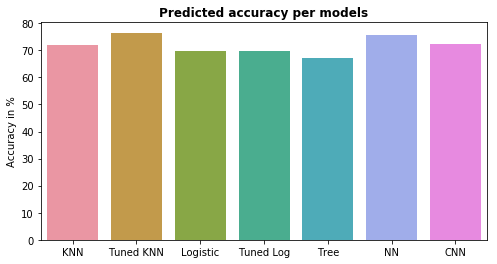

In [35]:
models_alt = ['KNN', 'Tuned KNN', 'Logistic', 'Tuned Log', 'Tree', 'NN', 'CNN']
accuracies_alt = [acc_knn_alt*100, acc_knn_cv*100, acc_log_alt*100, acc_log_cv*100, acc_tree_alt*100,  acc_test_final_2fc_alt, acc_test_final_cnn_alt]

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title('Predicted accuracy per models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy in %')
g = sns.barplot(x=models_alt, y = accuracies_alt, ax=ax)

## Conclusion

During this assignement, while taking two different approaches, I was able to obtain good accuracy score to classify the gender of a person based on speech samples. Of course, the first approach performs better than the second one as we are sure to have meaningful information fed to our models while training. However, while testing, it could be biased to consider that we can gather the same amount of meaningful information, it would be more likely that we have only a few seconds of speech from a speaker to test.
About the methods chosen to be used, I would say that I stayed with low complexity methods. Regarding the first approach, the low dimensionnality of the dataset was not appealing to use very complex models, and the simple models performs well. On the second approach however, more complex model would have been interesting to assess, but then the comparison to the first approach would have been unfair. Bottom line is that models decided to be used should fit the dataset in order to achieve the best performance.